# EECS 491 Final Project: Bayesian Structure and Parameter Learning

# Overview

Bayesian-network models are a commonly-used framework for modeling conditional probabilities, allowing extremely complicated conditional relationships to be modeled and implemented with ease. Previously in this course, we have covered in great detail how to perform inference operations given a defined bayesian-network model. This works well when we are able to construct an informed model, which includes the correct conditional probabilities and links. However, what are we to do when we are given lots of data, with no knowledge of the relationships between any of the variables or elements? Before we can perform any kind of predictive inference, we first need to learn a bayesian model from our data. This can generally be described in two parts: learning the structural relationship between probabilistic variables, and learning the conditional probability distributions which fit data to a given structure.

In [105]:
from graphviz import Graph, Digraph
import pgmpy
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import GibbsSampling
from pgmpy.estimators import ExhaustiveSearch, HillClimbSearch, ConstraintBasedEstimator
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import time

## True Model

In order to generate bayesian-networks from scratch, we need data to describe. Throughout this example, we will be using the following model (Adpted from Barber Exercise 3.6) that describes the probability of a car starting given certain factors. We will use this model to generate samples which will be used to generate networks and parameters, and then we will compare the accuracy of the generated models to the actual model.

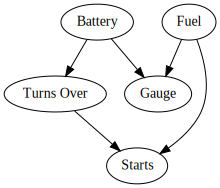

In [2]:
q5 = Digraph()
q5.node('b', 'Battery')
q5.node('g', 'Gauge')
q5.node('f', 'Fuel')
q5.node('t', 'Turns Over')
q5.node('s', 'Starts')
q5.edges(['bg','fg','bt','ts','fs'])
q5

In [131]:
# Create model from list of edges
model = BayesianModel([('B','G'),('F','G'),('B','T'),('T','S'),('F','S')])

# define p(B) and p(M) 
# variable_card is cardinality = 2 for true|false
# values are defined in numeric order p(x_i = [false, true]), ie  [0, 1]
priorB = TabularCPD(variable='B', variable_card=2, values=[[0.02, 0.98]])
priorF = TabularCPD(variable='F', variable_card=2, values=[[0.05, 0.95]])

# define p(G|B,F)
# Variables cycle in numerical order of evidence values,
# ie BF = 00, 01, 10, 11 for each value of G.
cpdG = TabularCPD(variable='G', variable_card=2, 
                  evidence=['B', 'F'], evidence_card=[2, 2],
                  values=[[0.99, 0.1, 0.97, 0.04], 
                          [0.01, 0.9, 0.03, 0.96]])

# define p(T|B)
cpdT = TabularCPD(variable='T', variable_card=2,
                 evidence=['B'], evidence_card=[2],
                 values=[[0.98, 0.03],
                         [0.02, 0.97]])

# define p(S|T,F)
cpdS = TabularCPD(variable='S', variable_card=2, 
                  evidence=['F','T'], evidence_card=[2, 2],
                  values=[[0.99, 0.92, 1.0, 0.01], 
                          [0.01, 0.08, 0.0, 0.99]])

# add probabilities to model
model.add_cpds(priorB, priorF, cpdG, cpdT, cpdS)
print('Model is valid: ', model.check_model())
print('True Model Edges: ',model.edges())

Model is valid:  True
True Model Edges:  [('B', 'G'), ('B', 'T'), ('F', 'G'), ('F', 'S'), ('T', 'S')]


Now that we have a defined model, let's generate some data using Gibbs sampling. Different amounts of samples are collected, in order to test the number of required samples for each of the later-implemented algorithms.

In [72]:
# generate sets of samples
sampler = GibbsSampling(model)
sample10 = sampler.sample(size=10, return_type='dataframe')
sample100 = sampler.sample(size=100, return_type='dataframe')
sample1000 = sampler.sample(size=1000, return_type='dataframe')
sample10000 = sampler.sample(size=10000, return_type='dataframe')

100%|██████████| 9999/9999 [00:04<00:00, 2380.44it/s]


# Parameter Learning

In this section, we will focus on the problem of fitting a given bayesian structure to real data. Specifically, this requires finding the conditional probability distributions (CPDs) for each variable such that the joint probability distribution $p(x)$ accurately describes the observed data.

## Maximum Likelihood Estimation

We can assume that in a bayesian network, the structure of $p(x)$ can be constrained as

$$p(x) = \prod_{i=1}^{K}p(x_i|pa(x_i)),$$

where $K$ is the number of variables, $x_i$ is a given variable and $pa(x_i)$ are the parents of $x_i$ in the directed acyclic graph.

One method of extimating the CPDs for each variable is to determine the maximum likelihood of each term. To do this, we can minimize the KL divergence between the data distribution $q(x)$ and $p(x)$. The setting which minimizes this divergence and maximizes the overall likelihood is

$$p(x_i|pa(x_i)) = q(x_i|pa(x_i),$$

which can be written in terms of the given data,

$$p(x_i=s|pa(x_i)=t) \propto \sum_{n=1}^{N}\mathbb{I}[x_i^n=s,pa(x_i^n)=t],$$

saying that each CPD table entry can be set by using the relative frequencies of each state, meaning that each entry is the ratio of the number of times the state $\{x_i=s,pa(x_i)=t\}$ occurs vs the sum of all other states $\{x_i=s',pa(x_i)=t\}$. This operation is fairly computationally efficient, as it just requires counting.

Below, we fit CPDs to our example problem given the correct structure, and compare our results to the true values using 10,000 samples.

In [132]:
mle_model = MaximumLikelihoodEstimator(model, sample10000)
mle_cpds = mle_model.get_parameters()

print('True Starts CPD:\n',cpdS)
print('MLE Starts CPD:\n',mle_cpds[3])

True Starts CPD:
 +------+------+------+------+------+
| F    | F(0) | F(0) | F(1) | F(1) |
+------+------+------+------+------+
| T    | T(0) | T(1) | T(0) | T(1) |
+------+------+------+------+------+
| S(0) | 0.99 | 0.92 | 1.0  | 0.01 |
+------+------+------+------+------+
| S(1) | 0.01 | 0.08 | 0.0  | 0.99 |
+------+------+------+------+------+
MLE Starts CPD:
 +------+------+---------------------+------+----------------------+
| F    | F(0) | F(0)                | F(1) | F(1)                 |
+------+------+---------------------+------+----------------------+
| T    | T(0) | T(1)                | T(0) | T(1)                 |
+------+------+---------------------+------+----------------------+
| S(0) | 1.0  | 0.9113924050632911  | 1.0  | 0.008637655805816751 |
+------+------+---------------------+------+----------------------+
| S(1) | 0.0  | 0.08860759493670886 | 0.0  | 0.9913623441941832   |
+------+------+---------------------+------+----------------------+


One CPD is displayed, for the sake of brevity. As we can see, the MLE method is able to approximate each of the tabld entries within an error of about 1%. Note however that MLE overfits to the data, as seen when the relationship in the first column is lost, as following the MLE results the car should never start in that condition. While that is acceptable in this problem, it may not be in others.

As we can see below, the accuracy of our model fit is dependent on the number and diversity of samples we receive. As the amount of available data decreases, our error in each entry also increases, and the overall CPD has less possibilities.

In [138]:
mle_model1000 = MaximumLikelihoodEstimator(model, sample1000)
mle_cpds1000 = mle_model1000.get_parameters()
mle_model100 = MaximumLikelihoodEstimator(model, sample100)
mle_cpds100 = mle_model100.get_parameters()
mle_model10 = MaximumLikelihoodEstimator(model, sample10)
mle_cpds10 = mle_model10.get_parameters()

print('True Starts CPD:\n',cpdS)
print('1000 Samples:\n',mle_cpds1000[3])
print('100 Samples:\n',mle_cpds100[3])
print('10 Samples:\n',mle_cpds10[3])

True Starts CPD:
 +------+------+------+------+------+
| F    | F(0) | F(0) | F(1) | F(1) |
+------+------+------+------+------+
| T    | T(0) | T(1) | T(0) | T(1) |
+------+------+------+------+------+
| S(0) | 0.99 | 0.92 | 1.0  | 0.01 |
+------+------+------+------+------+
| S(1) | 0.01 | 0.08 | 0.0  | 0.99 |
+------+------+------+------+------+
1000 Samples:
 +------+------+---------------------+------+---------------------+
| F    | F(0) | F(0)                | F(1) | F(1)                |
+------+------+---------------------+------+---------------------+
| T    | T(0) | T(1)                | T(0) | T(1)                |
+------+------+---------------------+------+---------------------+
| S(0) | 1.0  | 0.9478260869565217  | 1.0  | 0.01264367816091954 |
+------+------+---------------------+------+---------------------+
| S(1) | 0.0  | 0.05217391304347826 | 0.0  | 0.9873563218390805  |
+------+------+---------------------+------+---------------------+
100 Samples:
 +------+---------

## Bayesian Estimation

One alternative method which we can use to try and avoid overfitting to the data is a bayesian approach, where we maintain a distribution over the parameters. In order to do this we will make some assumptions, the first being that the parameters are globally independent,

$$p(\theta_1,\theta_2,...,\theta_n) = p(\theta_1)p(\theta_2)...p(\theta_n).$$

The second assumption we'll make is that the local parameters are also independent,

$$p(\theta_i) = p(\theta_i^{0,0,...,0})p(\theta_i^{0,1,...,0})...p(\theta_i^{1,1,...,1}).$$

We'll use a general multivariate model, even though our example only consists of binary states. For our conjugate prior, we'll use the Dirichlet distribution. Since our posterior factorizes over the variables due to the global independence assumption, each posterior table for a variable depends only on the data $D(v)$ of the variable's family. With the Dirichlet prior

$$p(\theta(v;j)) = Dirichlet(\theta(v,j)|u(v;j))$$

where $u$ is the Dirichlet hyperparameters, the posterior is also a Dirichlet

$$p(\theta(v)|D(v)) = \prod_jDirichlet(\theta(v;j)|u'(v;j)),$$

where $u'$ is the updated hyperparameter prior, given by

$$u_i'(v;j) = u_i(v;j)+\#(v=i,pa(v)=j)$$

with $\#$ denoting the number of counts in the data for that state. This leads to a likelihood (or *score*) which we can iteratively maximize, given by

$$p(D) = \prod_k\prod_np(v_k^n|pa(v_k^n)) = \prod_k\prod_j\frac{Z(u'(v_k;j))}{Z(u(v_k;j))},$$

where $Z(u)$ is the normalization constant of a Dirichlet distribution with hyperparameters $u$.

There are a couple of methods for initializing the Dirichlet prior hyperparameters $u$. The first, and most straightforward, way is to set all of the values $u_i(v;j)$ to 1. This is refered to as the *K2* prior. Another method is known as the *BDeu* (Bayesian Dirichlet equivalent uniform prior), where the hyperparameters are set by

$$u_i(v;j) = \frac{\alpha}{dim(v)dim(pa(v))},$$

with an equivalent sample size $\alpha$. Varying this parameter influences the performance of the estimation. We compare the performance of these two different priors below.

In [137]:
bayesEst = BayesianEstimator(model, sample1000)
k2_cpds = bayesEst.get_parameters(prior_type='K2')
bd_cpds = bayesEst.get_parameters(prior_type='BDeu',equivalent_sample_size=5)

print('True Starts CPD:\n',cpdS)
print('K2 Starts CPD:\n',k2_cpds[4])
print('BDeu Starts CPD:\n',bd_cpds[4])

True Starts CPD:
 +------+------+------+------+------+
| F    | F(0) | F(0) | F(1) | F(1) |
+------+------+------+------+------+
| T    | T(0) | T(1) | T(0) | T(1) |
+------+------+------+------+------+
| S(0) | 0.99 | 0.92 | 1.0  | 0.01 |
+------+------+------+------+------+
| S(1) | 0.01 | 0.08 | 0.0  | 0.99 |
+------+------+------+------+------+
K2 Starts CPD:
 +------+------+---------------------+---------------------+----------------------+
| F    | F(0) | F(0)                | F(1)                | F(1)                 |
+------+------+---------------------+---------------------+----------------------+
| T    | T(0) | T(1)                | T(0)                | T(1)                 |
+------+------+---------------------+---------------------+----------------------+
| S(0) | 0.8  | 0.9401709401709402  | 0.9285714285714286  | 0.013761467889908258 |
+------+------+---------------------+---------------------+----------------------+
| S(1) | 0.2  | 0.05982905982905983 | 0.071428571428

We can see above that both choices of prior lead to a more conservative estimation of the CPDs than MLE, with the BDeu prior having more accuracy than the K2 prior. We see more error than MLE (13% error vs 1%), however the relationship is still preserved. Varying the $\alpha$ parameter for the BDeu prior leads to changes in performance, shown below.

In [139]:
bd_cpds1 = bayesEst.get_parameters(prior_type='BDeu',equivalent_sample_size=1)
bd_cpds10 = bayesEst.get_parameters(prior_type='BDeu',equivalent_sample_size=10)
bd_cpds100 = bayesEst.get_parameters(prior_type='BDeu',equivalent_sample_size=100)
bd_cpds1000 = bayesEst.get_parameters(prior_type='BDeu',equivalent_sample_size=1000)

print('True Starts CPD:\n',cpdS)
print('alpha = 1 Starts CPD:\n',bd_cpds1[4])
print('alpha = 10 Starts CPD:\n',bd_cpds10[4])
print('alpha = 100 Starts CPD:\n',bd_cpds100[4])
print('alpha = 1000 Starts CPD:\n',bd_cpds1000[4])

True Starts CPD:
 +------+------+------+------+------+
| F    | F(0) | F(0) | F(1) | F(1) |
+------+------+------+------+------+
| T    | T(0) | T(1) | T(0) | T(1) |
+------+------+------+------+------+
| S(0) | 0.99 | 0.92 | 1.0  | 0.01 |
+------+------+------+------+------+
| S(1) | 0.01 | 0.08 | 0.0  | 0.99 |
+------+------+------+------+------+
alpha = 1 Starts CPD:
 +------+----------------------+---------------------+---------------------+----------------------+
| F    | F(0)                 | F(0)                | F(1)                | F(1)                 |
+------+----------------------+---------------------+---------------------+----------------------+
| T    | T(0)                 | T(1)                | T(0)                | T(1)                 |
+------+----------------------+---------------------+---------------------+----------------------+
| S(0) | 0.9615384615384616   | 0.9468546637744034  | 0.9897959183673469  | 0.012783682849755817 |
+------+----------------------+-

As $\alpha$ is increased, the estimated CPD table entries become more and more conservative.

Additionally, performance is also dependent on the amount of data available, just as with MLE.

In [140]:
bayesEst10 = BayesianEstimator(model, sample10)
bayesEst100 = BayesianEstimator(model, sample100)
bayesEst1000 = BayesianEstimator(model, sample1000)

bd_cpds10 = bayesEst10.get_parameters(prior_type='BDeu',equivalent_sample_size=5)
bd_cpds100 = bayesEst100.get_parameters(prior_type='BDeu',equivalent_sample_size=5)
bd_cpds1000 = bayesEst1000.get_parameters(prior_type='BDeu',equivalent_sample_size=5)

print('True Starts CPD:\n',cpdS)
print('10 Samples Starts CPD:\n',bd_cpds10[4])
print('100 Samples Starts CPD:\n',bd_cpds100[4])
print('1000 Samples Starts CPD:\n',bd_cpds1000[4])

True Starts CPD:
 +------+------+------+------+------+
| F    | F(0) | F(0) | F(1) | F(1) |
+------+------+------+------+------+
| T    | T(0) | T(1) | T(0) | T(1) |
+------+------+------+------+------+
| S(0) | 0.99 | 0.92 | 1.0  | 0.01 |
+------+------+------+------+------+
| S(1) | 0.01 | 0.08 | 0.0  | 0.99 |
+------+------+------+------+------+
10 Samples Starts CPD:
 +------+---------------------+--------------------+
| F    | F(1)                | F(1)               |
+------+---------------------+--------------------+
| T    | T(0)                | T(1)               |
+------+---------------------+--------------------+
| S(0) | 0.6428571428571429  | 0.1956521739130435 |
+------+---------------------+--------------------+
| S(1) | 0.35714285714285715 | 0.8043478260869565 |
+------+---------------------+--------------------+
100 Samples Starts CPD:
 +------+--------------------+----------------------+
| F    | F(0)               | F(1)                 |
+------+------------------

# Structure Learning

Now that we are able to fit conditional probabilities to a given bayesian-network structure, our next task is to generate a structure (Directed-Acyclic Graph) which best matches this data.

## Network Scoring

The first family of methods we will explore which achieve this are *network scoring* techniques. These methods are similar to traditional numerical optimization, where we are trying to find the model structure $M$ which maximizes the network score $p(M|D)$, which is the probability that our model fits the original data. This requires generating multiple possible models, and comparing their individual scores. In order to evaluate the score of a given model, we can compute an approximation of $p(M|D)$ given that

$$p(M|D) \propto p(D|M)p(M).$$

From here we have to fit each model to the data, using one of the parameter learning methods described above. We will specifically use the bayesian parameter estimation method, since maximum likelihood estimation will tend towards more complex structures. Since we will be using a bayesian framework with Dirichlet priors, we can use the score equation we previously defined in the bayesian estimation section, along with our K2 or BDeu prior. Since the best performance was found using BDeu before, we will continue to use the BDeu prior in this section.

### Exhaustive Search

The simplest method to search through model space is an exhaustive search, i.e. testing every possible combination of edges and directions. While this is simple to implement and guarantees finding the structure which absolutely the best score, this method can quickly become computationally intractable. Given that a network with $n$ nodes has $\frac{n(n-1)}{2}$ distinct pairs of nodes, then for every pair there are three types of connections, meaning that there are a total of $3^{\frac{n(n-1)}{2}}$ possible connected graphs. This means that this approach is infeasable for all but the simplest of toy problems.

In [141]:
es = ExhaustiveSearch(sample10000, scoring_method=BDeuScore(sample10000, equivalent_sample_size=1))
start = time.time()
es_model = es.estimate()
end = time.time()
print(es_model.edges())
print("Elapsed Time:", end-start, ' sec')

[('B', 'T'), ('F', 'G'), ('F', 'S'), ('T', 'S')]
Elapsed Time: 220.1201663017273  sec


While simple, the exhaustive search is very slow. This method (along with other search methods) is also heavily tied to the samples used. As can be seen above, even for this simple network and 10,000 samples, the algorithm is only able to find four out of the five connections.

### Hill Climbing

Another, more practical search method is a *Hill Climbing* search. In this method, we can start from a network with no connections and iteratively generate single connections which maximize the network score. This is possible because the overall score is comprised of additive terms of each node family. Due to this relationship, the change in score due to a single edge is not influenced by any other edge and we can use local heuristics entirely. Since we are only using local heuristics, we stop searching when we reach a local maximum.

In [147]:
hc = HillClimbSearch(sample10, scoring_method=BDeuScore(sample10, equivalent_sample_size=1))
start = time.time()
best_model = hc.estimate()
end = time.time()
print("10 Samples: ",best_model.edges())
print("Elapsed Time:", end-start, ' sec')

hc = HillClimbSearch(sample100, scoring_method=BDeuScore(sample100, equivalent_sample_size=1))
best_model = hc.estimate()
print("100 Samples: ",best_model.edges())

hc = HillClimbSearch(sample1000, scoring_method=BDeuScore(sample1000, equivalent_sample_size=1))
best_model = hc.estimate()
print("1000 Samples: ",best_model.edges())

hc = HillClimbSearch(sample10000, scoring_method=BDeuScore(sample10000, equivalent_sample_size=1))
best_model = hc.estimate()
print("10000 Samples: ",best_model.edges())

10 Samples:  [('B', 'T'), ('B', 'S'), ('S', 'T')]
Elapsed Time: 0.4325718879699707  sec
100 Samples:  [('G', 'F'), ('F', 'S')]
1000 Samples:  [('G', 'F'), ('F', 'S'), ('T', 'S'), ('T', 'B')]
10000 Samples:  [('G', 'F'), ('F', 'S'), ('T', 'S'), ('T', 'B')]


As we can see, this algorithm runs significantly faster than the exhaustive search method. However just like all of the other methods we have seen, its performance is dependent on the amount of data available. The outcome of the algorithm is also dependent on the value of $\alpha$, as shown below.

In [148]:
hc = HillClimbSearch(sample10000, scoring_method=BDeuScore(sample10000, equivalent_sample_size=1))
best_modelhc1 = hc.estimate()
print("alpha = 1: ",best_modelhc1.edges())

hc = HillClimbSearch(sample10000, scoring_method=BDeuScore(sample10000, equivalent_sample_size=10))
best_modelhc10 = hc.estimate()
print("alpha = 10: ",best_modelhc10.edges())

hc = HillClimbSearch(sample10000, scoring_method=BDeuScore(sample10000, equivalent_sample_size=100))
best_modelhc100 = hc.estimate()
print("alpha = 100: ",best_modelhc100.edges())

hc = HillClimbSearch(sample10000, scoring_method=BDeuScore(sample10000, equivalent_sample_size=1000))
best_modelhc1000 = hc.estimate()
print("alpha = 1000: ",best_modelhc1000.edges())

alpha = 1:  [('G', 'F'), ('F', 'S'), ('T', 'S'), ('T', 'B')]
alpha = 10:  [('B', 'T'), ('G', 'B'), ('F', 'G'), ('F', 'S'), ('T', 'S')]
alpha = 100:  [('B', 'G'), ('B', 'F'), ('F', 'G'), ('T', 'B'), ('T', 'F'), ('T', 'G'), ('S', 'F'), ('S', 'T'), ('S', 'B'), ('S', 'G')]
alpha = 1000:  [('B', 'F'), ('B', 'G'), ('B', 'S'), ('G', 'F'), ('G', 'S'), ('F', 'S'), ('T', 'S'), ('T', 'B'), ('T', 'F'), ('T', 'G')]


As the value of $\alpha$ is increased, the complexity of the optimized structure also increases. In this example, an $\alpha$ of 10 gets the best performance, beating the exhaustive search method. However, while all of the correct links are present, the causality of one of the relationships is reversed.

## PC Algorithm

A different form of structure learning, which is different from those we have described above, is the *PC* algorithm. This is a constraint-based estimator, where a structure is created based on empirical local dependencies.

### Determining Independence

Since this algorithm is based on dependencies, a method is needed for testing variable independence. This is estimating using the distribution $p(x,y,z)$ over the variables x, y, and z by counting their occurances in the data. We compute the distribution of their conditional mutual information,

$$2\textit{N}MI(x;y|z),$$

which is a $\chi^2$ distribution with

$$(dim(x)-1)(dim(y)-1)dim(z)$$

degrees of freedom. If a sample is in the tails of the distribution within a significance threshold, then the variables are conditionally dependent.

### Creating the Skeleton

The PC algorithm first creates a skeleton of the bayesian network, over multiple rounds. The first round starts with an all-to-all connected, undirected graph, and the overall goal is to remove as many links as possible. In the first round, all $x-y$ pairs are tested for $x\perp\!\!\!\perp y|\emptyset$. If the variables are independent, then the link between them is removed.

In the remaining rounds, all $x-y$ pairs are tested along with neighbors z, where the number of neighbors is increased by one every round. If $x\perp\!\!\!\perp y|z$ is true, then the link $x-y$ is removed. This process is repeated until there is no change between rounds.

### Orienting the Skeleton

Once the skeleton has been created, we don't have a full bayesian belief network yet. In order for that, we need to orient the edges into a directed acyclic graph. For each set of neighboring variables $x-z-y$, the following test is performed. If $x\perp\!\!\!\perp y|\emptyset$ then z is a collider variable, and the links should be oriented as

$$x\rightarrow z \leftarrow y.$$

If $x\perp\!\!\!\perp y|z$ is true however, then z is not a collider and the links are

$$x\leftarrow z \rightarrow y.$$

We can now run our algorithm for our example problem.

In [78]:
PCest = ConstraintBasedEstimator(sample10)
start = time.time()
skel, seperating_sets = PCest.estimate_skeleton(significance_level=0.01)
pdag = PCest.skeleton_to_pdag(skel, seperating_sets)
PCmodel = PCest.pdag_to_dag(pdag)
end = time.time()

print("Elapsed Time: ", end-start, " sec")
print("Undirected edges: ", skel.edges())
print("PDAG edges:       ", pdag.edges())
print("DAG edges:        ", model.edges())

Elapsed Time:  0.315032958984375  sec
Undirected edges:  [('G', 'F')]
PDAG edges:        [('G', 'F'), ('F', 'G')]
DAG edges:         [('B', 'G'), ('B', 'T'), ('F', 'G'), ('F', 'S'), ('T', 'S')]


As we can see, for our example problem the PC algorithm is the best structure-learning algorithm we can use. All of our edges are corrrectly identified with the correct causality relationships, and can be done in a similar time with three orders-of-magnitude less samples.